In [75]:
# ============================================================
# Notebook setup
# ============================================================

%reload_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

from util import cst
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, callbacks
#from tensorflow_probability import distributions
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras import backend as k

stop = 1400



# Domain Knowledge Injection via SBR

## Scarce Labels in RUL Predictions

**In our RUL use case we had access to many run-to-failure experiments**

In practice, this is _seldom the case_

* Run-to-failure experiments are time consuming
* They may not be viable for large and complex machines
* Typically, _only a few runs_ are available

**However, data about _normal_ operation may still be abundant**

* This may come from test runs, installed machines, etc.
* It looks exactly like the input data for our RUL prediction model
* ...And it will still show sign of component wear

However, _the true RUL value in this case will be unknown_

> **Can we still take advantage of this data?**

## Domain Knowledge in Machine Learning

**We can take an _anomaly detection_ approach**

* We can use an AE or a density estimator to generate an _anomaly signal_
* Then we can _optimize a threshold_ based on the few run-to-failure experiments

This approach may work, but:

* Signals for different machines may grow at different rates
* ...Thus making the generalization difficult to achieve

**We can resort to autoencoders and use _semi-supervised learning_:**

* We train an autoencoder on the unsupervised data, then remove the decoder
* ...We replace them it with classification layers, trained on the supervised data

Another viable technique, but with _one drawback_

* Since the AE is trained for a task very different from RUL prediction
* ...There is no guarantee that the learned encoding is well suited for that


## Domain Knowledge in Machine Learning

**We will investigate here _a different approach_**

* We will use _domain knowledge_ to get information from the unsupervised data
* We will then inject such information in the model by means of _constraints_

**This approach introduces _a new source of information_**

* The domain knowledge may be provided by experts
* ...Or it may be a second, heterogeneous model (e.g. a physical model)

**In the remainder of the notebook**

* We will first address the problem using only the supervised information
* ...Then we will see how to use domain knowledge to exploit unsupervised data

**The approach is not limited to RUL prediction**

* The techniques we will see work for a wide variety of constraints 


# Our Baseline Approach

## Data Loading and Preparation

**Let's start by loading our old dataset**

We will focus on the FD004 data:

### Data loading

In [103]:
# Load data
data_folder = '/app/data'
data = cst.load_cmapss_data(data_folder)
# Identify input columns
dt_in = list(data.columns[3:-1])

### Data inspection
- *src* is the train surce 
- *machine* is the number associated to a single machine
- *p* are the controlled parameters
- *s* are the sensors
- *rul* is the remaining useful life, namely the label 

In [3]:
data.head()

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD001,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,train_FD001,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,train_FD001,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,train_FD001,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,train_FD001,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


Example of machine 1: the rul value goes from 191 to 0 decreasing monotonically

In [77]:
#print the data with 'machine' = 1
data[data['machine'] == 1].head(len(data[data['machine'] == 1]))

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD001,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,train_FD001,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,train_FD001,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,train_FD001,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,train_FD001,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,train_FD001,1,188,-0.0067,0.0003,100.0,518.67,643.75,1602.38,1422.78,...,2388.23,8117.69,8.5207,0.03,396,2388,100.0,38.51,22.9588,4
188,train_FD001,1,189,-0.0006,0.0002,100.0,518.67,644.18,1596.17,1428.01,...,2388.33,8117.51,8.5183,0.03,395,2388,100.0,38.48,23.1127,3
189,train_FD001,1,190,-0.0027,0.0001,100.0,518.67,643.64,1599.22,1425.95,...,2388.35,8112.58,8.5223,0.03,398,2388,100.0,38.49,23.0675,2
190,train_FD001,1,191,-0.0000,-0.0004,100.0,518.67,643.34,1602.36,1425.77,...,2388.30,8114.61,8.5174,0.03,394,2388,100.0,38.45,23.1295,1


We will plot a histogram showing the distribution of max rul values for each machine

<Axes: >

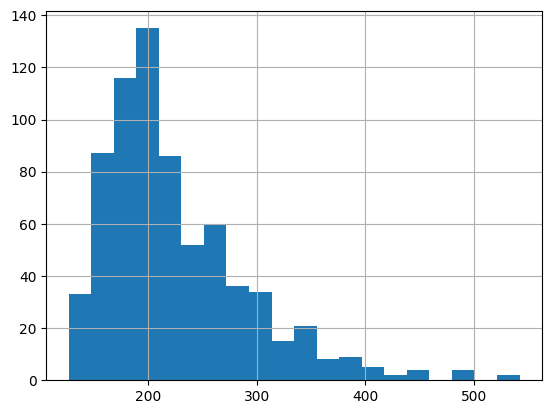

In [125]:
#define a histogram with value of rul for each machine where cycle=1 and src='FD001'
data[data['cycle'] == 1].groupby(['machine']).max()['rul'].hist(bins=20)


In [140]:
#standardize data
data_sv = data.copy()
data_sv[dt_in] = (data_sv[dt_in] - data_sv[dt_in].mean()) / data_sv[dt_in].std()

In [141]:
data_by_src = cst.split_by_field(data_sv, field='src')

We inspect data by plotting heatmaps. We consider only data conatined in train_FD004, which has 6 operating conditions and 2 fault modes

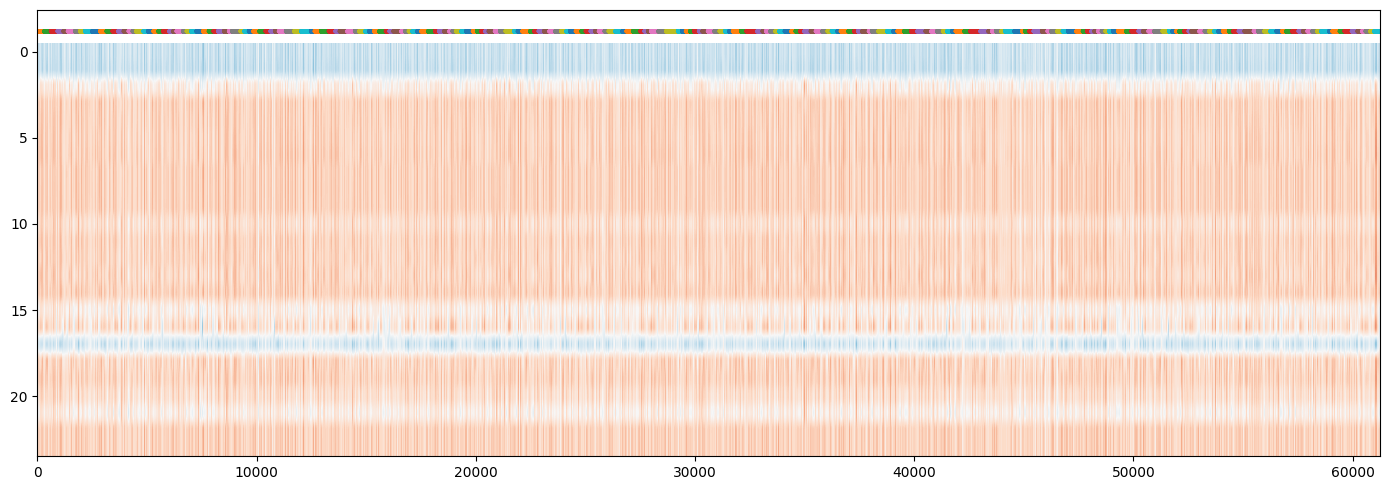

In [142]:
data_sv = data_by_src["train_FD004"]
cst.plot_dataframe(data_sv[dt_in], labels=data_sv['machine'], figsize=figsize)

There is a high varibaility in the plotted series, which is the result of multiple operating conditions

We will then inspect in detail a column providing information on a given sensor, to see if there is any claer trend in the data.

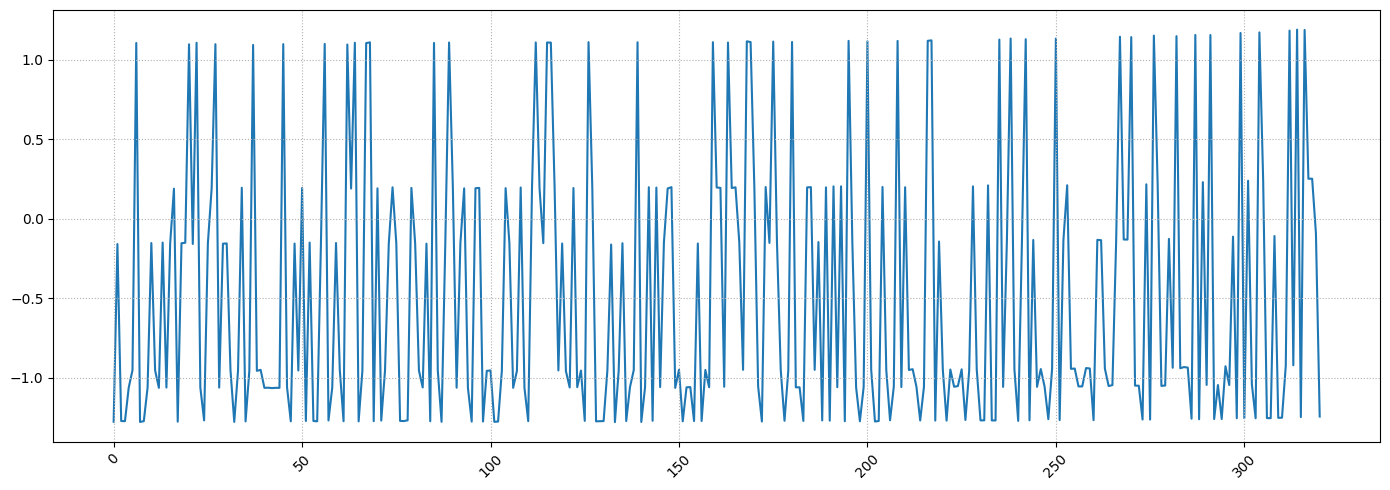

In [143]:
tmp = data_sv[data_sv['machine'] == data_sv['machine'].iloc[0]]
cst.plot_series(tmp['s7'], figsize=figsize)

There is a weak trend tied to component wear, and it is mainly covered by wide oscillations. 

In [144]:
#we use just dataset 4
dt = data_by_src["train_FD004"]

In [145]:
dt.head()

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD004,461,1,1.500057,1.168664,0.345954,-1.342550,-1.122474,-1.045952,-1.086033,...,0.344929,-0.175148,0.370889,-1.037783,-0.989600,-0.433322,0.345954,-1.310594,-1.311278,320
1,train_FD004,461,2,0.168806,0.788709,0.345954,0.175840,0.205021,0.089480,-0.172094,...,0.342590,-0.531124,0.181688,-1.037783,0.009709,0.352571,0.345954,-0.134518,-0.129792,319
2,train_FD004,461,3,1.499991,1.171110,0.345954,-1.342550,-1.139659,-1.048575,-1.055806,...,0.344749,-0.276979,0.460301,-1.037783,-1.021836,-0.433322,0.345954,-1.322569,-1.303537,318
3,train_FD004,461,4,1.499761,1.168664,0.345954,-1.342550,-1.145544,-1.064484,-1.048616,...,0.345198,-0.160016,0.375413,-1.037783,-1.054071,-0.433322,0.345954,-1.317437,-1.304065,317
4,train_FD004,461,5,0.471584,0.572641,-2.890543,-0.765963,-1.442165,-1.792301,-1.668131,...,-2.892626,-2.767824,2.370806,-1.037783,-1.795494,-2.517341,-2.890543,-1.018927,-0.982214,316


We then simulate the scarcity of run-to-failure experiments:

In [9]:
trs_ratio = 0.03 # Ratio of supervised experiments
tru_ratio = 0.75 # Ration of supervised and unsupervised data -> unsupervised data: 0.72

np.random.seed(42)
machines = dt.machine.unique()
np.random.shuffle(machines)

sep_trs = int(trs_ratio * len(machines))
sep_tru = int(tru_ratio * len(machines))

trs_mcn = list(machines[:sep_trs]) #prende machines con dati supervisionati
tru_mcn = list(machines[sep_trs:sep_tru]) #prende machines con dati non supervisionati
ts_mcn = list(machines[sep_tru:]) #restanti per test (25% del totale)

In [10]:
print(f'Num. machine: {len(trs_mcn)} (supervised), {len(tru_mcn)} (unsupervised), {len(ts_mcn)} (test)')

Num. machine: 7 (supervised), 179 (unsupervised), 63 (test)


We can then split the dataset according to this machine groups:

In [11]:
tr, ts = cst.partition_by_machine(dt, trs_mcn + tru_mcn)
trs, tru = cst.partition_by_machine(tr, trs_mcn)

Let's check the number of examples for each group:

In [12]:
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 1376 (supervised), 44009 (unsupervised), 15864 (test)


## Project

**We will run multiple experiments on our data to analyse the effect of domain knowledge injection via multiple approaches.**

- In the first 3 tasks we will experiment with different ratios and combinations of supervised and unsupervised data.
- In task 4 we will use a static regularizer to inject domain knowledge (RUL>0). 
- In task 5 we will use a lagrangian approach to dynamically maximize the weight of the regularizer.

#### TODO: spostare queste funzioni in util (nb decidere se fare anche funzione per train)

In [146]:
#function to standardize data and normalize rul values
def standardize(data):
    trmean = data[dt_in].mean() #NB dt_in selects columns with sensors data
    trstd = data[dt_in].std().replace(to_replace=0, value=1) # handle static fields

    trs_s = data.copy()
    trs_s[dt_in] = (trs_s[dt_in] - trmean) / trstd #standardize train set 
    trmaxrul = trs_s['rul'].max()
    
    trs_s['rul'] = trs_s['rul'] / trmaxrul
    return trs_s

In [254]:
def split_machines(data, supervised, unsupervised):
    np.random.seed(42)
    machines = data.machine.unique()
    np.random.shuffle(machines)

    sep_trs = int(supervised * len(machines))
    sep_tru = int(unsupervised * len(machines))
    
    
    if unsupervised == 0:
        trs_mcn = list(machines[:sep_trs]) #prende machines con dati supervisionati
        ts_mcn = list(machines[sep_trs:]) #restanti per test (25% del totale)
        print(f'Num. machines: {len(trs_mcn)} (supervised), {len(ts_mcn)} (test)')
        return cst.partition_by_machine(dt, trs_mcn)
    
    elif supervised == 0:
        tru_mcn = list(machines[:sep_tru]) #prende machines con dati unsupervisised
        ts_mcn = list(machines[sep_tru:]) #restanti per test (25% del totale)
        print(f'Num. machines: {len(tru_mcn)} (unsupervised), {len(ts_mcn)} (test)')
        return cst.partition_by_machine(dt, tru_mcn)
    
    else:
        trs_mcn = list(machines[:sep_trs]) #prende machines con dati supervisionati
        tru_mcn = list(machines[sep_trs:sep_tru]) #prende machines con dati non supervisionati
        ts_mcn = list(machines[sep_tru:]) #restanti per test (25% del totale)
        print(f'Num. machines: {len(trs_mcn)} (supervised), {len(tru_mcn)} (unsupervised), {len(ts_mcn)} (test)')
        tr, ts = cst.partition_by_machine(dt, trs_mcn + tru_mcn)
        trs, tru = cst.partition_by_machine(tr, trs_mcn)
        return tr, ts, trs, tru

In [ ]:
def evaluation(pred, ts_s):
    mse_seeds = []
    for i in pred:
        mse_seeds.append(mean_squared_error(ts_s["rul"], i)) # Calcola la media e la deviazione standard delle MSE
    mse_mean = np.mean(mse_seeds) 
    mse_std = np.std(mse_seeds) 
    print(f'Media della MSE: {mse_mean:.4f}\nDeviazione standard della MSE: {mse_std:.4f}')
    return mse_seeds, mse_mean, mse_std

def plot_results(mse_seeds, mse_mean, mse_std):
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(mse_seeds)), mse_seeds)
    plt.xticks(range(0,len(mse_seeds)))
    plt.axhline(y = mse_mean, color = 'r', linestyle = '--')
    plt.axhline(y = mse_mean + mse_std, color = 'y', linestyle = ':')
    plt.axhline(y = mse_mean - mse_std, color = 'y', linestyle = ':')
    plt.ylabel('MSE')
    plt.xlabel('Seed')
    plt.title('MSE distribution')
    plt.show()

In [229]:
def split_data(trs=0, tru=0, trs_ratio=0, tru_ratio=0):
    if type(tru) == int: #only supervised data
        sep_trs = int(trs_ratio * len(trs))
        trs = trs[:sep_trs]
        print(f'Num. samples: {len(trs)} (supervised), {len(ts)} (test)')
        return trs
    
    elif type(trs) == int: #only unsupervised data
        sep_tru = int(tru_ratio * len(tru))
        tru = tru[:sep_tru]
        print(f'Num. samples: {len(tru)} (unsupervised), {len(ts)} (test)')
        return tru
    
    else: #mixed data
        sep_trs = int(trs_ratio * len(trs))
        sep_tru = int(tru_ratio * len(tru))
        trs = trs[:sep_trs]
        tru = tru[:sep_tru]
        print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(ts)} (test)')
        return trs, tru

In [206]:
def remove_rul(tru_s):
    tru_s_by_m = cst.split_by_field(tru_s, 'machine')
    np.random.seed(42)
    for mcn, tmp in tru_s_by_m.items():  # mcn: macchina, tmp: dati di quella macchina
        cutoff = int(np.random.randint(10, 50, 1))    
        tru_s_by_m[mcn] = tmp.iloc[:-cutoff]
    tru_st = pd.concat(tru_s_by_m.values())
    tru_st['rul'] = -1.0 #we assign invalid rul values to unsupervised data
    return tru_st

## MLP model

**We can now define and train a MLP model with different combinations of data**

In this case, we have wrapped its code in a class:

```python
class MLPRegressor(keras.Model):
    def __init__(self, input_shape, hidden=[]):
        super(MLPRegressor, self).__init__()
        self.lrs = [layers.Dense(h, activation='relu') for h in hidden]
        self.lrs.append(layers.Dense(1, activation='linear'))

    def call(self, data):
        x = data
        for layer in self.lrs: x = layer(x)
        return x
```

* We are subclassing `keras.Model` and inheriting all its methods
* The `__init__` method builds the necessary layers
* The `call` method computes the predictions

### Task 1: train the model with only supervised data. We will experiment with different ratios of supervised data. 
In general, we expect that using higher ratios of supervised data will ensure better performances. However, if the model is too simple, it may incur in overfitting. 
- We expect that all the models trained with supervised data are the ones performing better. 
- Moreover, we expect that they learn the decreasing tred and also to predict the failure in an accurate way.
- We foresee that using 100% of supervised data will ensure the best results, however we do not expect that the differences in performances won't be as significant as those in the models with both supervised and unsupervised data. 

#### 1.1 100% of supervised data used for training

In [224]:
trs, ts = split_machines(dt, 0.75, 0)

Num. machine: 186 (supervised), 63 (test)


In [153]:
print(f'Num. samples: {len(trs)} (supervised), {len(ts)} (test)')

Num. samples: 45385 (supervised), 15864 (test)


In [154]:
trs_s = standardize(trs)
trmaxrul = trs_s['rul'].max()
ts_s = standardize(ts) 

We train the model (seed 42)

In [155]:
pred = []
for i in range(3):
    np.random.seed(i)
    nn = cst.MLPRegressor(input_shape=len(dt_in), hidden=[32, 32])
    nn.compile(optimizer='Adam', loss='mse')
    history = nn.fit(trs_s[dt_in], trs_s['rul'], validation_split=0.2, batch_size=32, epochs=20, verbose=1)
    pred.append(nn.predict(ts_s[dt_in]))

Epoch 1/20
1135/1135 [==============================] - 1s 699us/step - loss: 0.0200 - val_loss: 0.0124
Epoch 2/20
1135/1135 [==============================] - 1s 642us/step - loss: 0.0149 - val_loss: 0.0112
Epoch 3/20
1135/1135 [==============================] - 1s 690us/step - loss: 0.0145 - val_loss: 0.0110
Epoch 4/20
1135/1135 [==============================] - 1s 626us/step - loss: 0.0142 - val_loss: 0.0108
Epoch 5/20
1135/1135 [==============================] - 1s 674us/step - loss: 0.0142 - val_loss: 0.0115
Epoch 6/20
1135/1135 [==============================] - 1s 639us/step - loss: 0.0139 - val_loss: 0.0109
Epoch 7/20
1135/1135 [==============================] - 1s 675us/step - loss: 0.0138 - val_loss: 0.0124
Epoch 8/20
1135/1135 [==============================] - 1s 836us/step - loss: 0.0137 - val_loss: 0.0117
Epoch 9/20
1135/1135 [==============================] - 1s 641us/step - loss: 0.0136 - val_loss: 0.0108
Epoch 10/20
1135/1135 [==============================] - 1s 641u

Evaluation on the test set

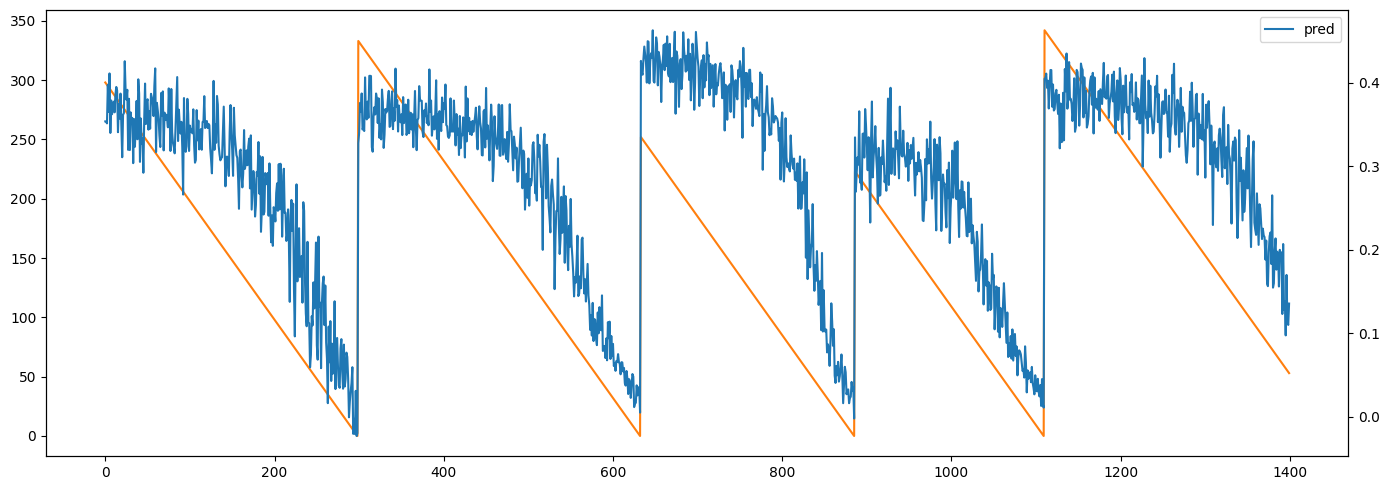

In [156]:
ts_pred = pred[0].ravel() * trmaxrul
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [169]:
mse_seeds, mse_mean, mse_std = evaluation(pred, ts_s)

Media della MSE: 0.0211
Deviazione standard della MSE: 0.0005


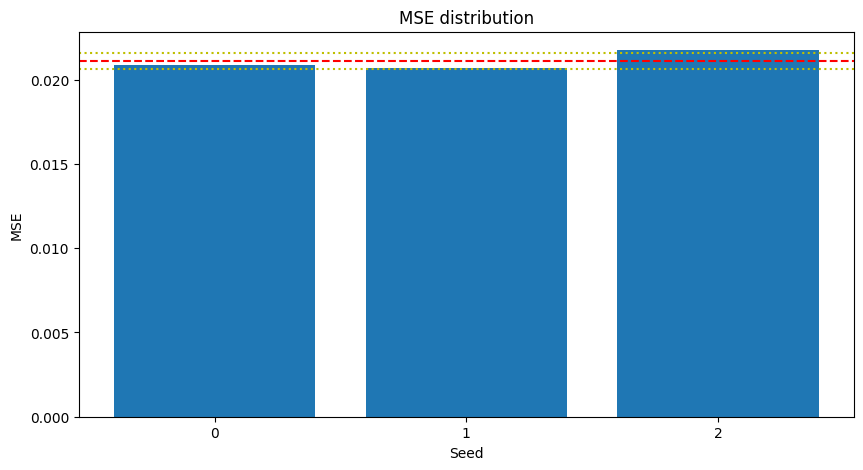

In [172]:
plot_results(mse_seeds, mse_mean, mse_std)

#### 1.2 75% of supervised data used for training

In [228]:
trs_2 = split_data(trs=trs, trs_ratio=0.75)

Num. samples: 34038 (supervised), 15864 (test)


In [187]:
trs_s = standardize(trs_2)
trmaxrul = trs_s['rul'].max()
ts_s = standardize(ts) 

In [287]:
pred = []
for i in range(3):
    np.random.seed(i)
    nn = cst.MLPRegressor(input_shape=len(dt_in), hidden=[32, 32])
    nn.compile(optimizer='Adam', loss='mse')
    history = nn.fit(trs_s[dt_in], trs_s['rul'], validation_split=0.2, batch_size=32, epochs=20, verbose=1)
    pred.append(nn.predict(ts_s[dt_in]).ravel() * trmaxrul)

Epoch 1/20
765/765 [==============================] - 1s 655us/step - loss: 0.0242 - val_loss: 0.0170
Epoch 2/20
765/765 [==============================] - 0s 602us/step - loss: 0.0173 - val_loss: 0.0144
Epoch 3/20
765/765 [==============================] - 0s 579us/step - loss: 0.0165 - val_loss: 0.0149
Epoch 4/20
765/765 [==============================] - 0s 641us/step - loss: 0.0159 - val_loss: 0.0149
Epoch 5/20
765/765 [==============================] - 0s 575us/step - loss: 0.0157 - val_loss: 0.0138
Epoch 6/20
765/765 [==============================] - 0s 574us/step - loss: 0.0155 - val_loss: 0.0143
Epoch 7/20
765/765 [==============================] - 0s 579us/step - loss: 0.0153 - val_loss: 0.0139
Epoch 8/20
765/765 [==============================] - 0s 579us/step - loss: 0.0154 - val_loss: 0.0150
Epoch 9/20
765/765 [==============================] - 0s 581us/step - loss: 0.0151 - val_loss: 0.0141
Epoch 10/20
765/765 [==============================] - 0s 594us/step - loss: 0.015

Evaluation on the test set 

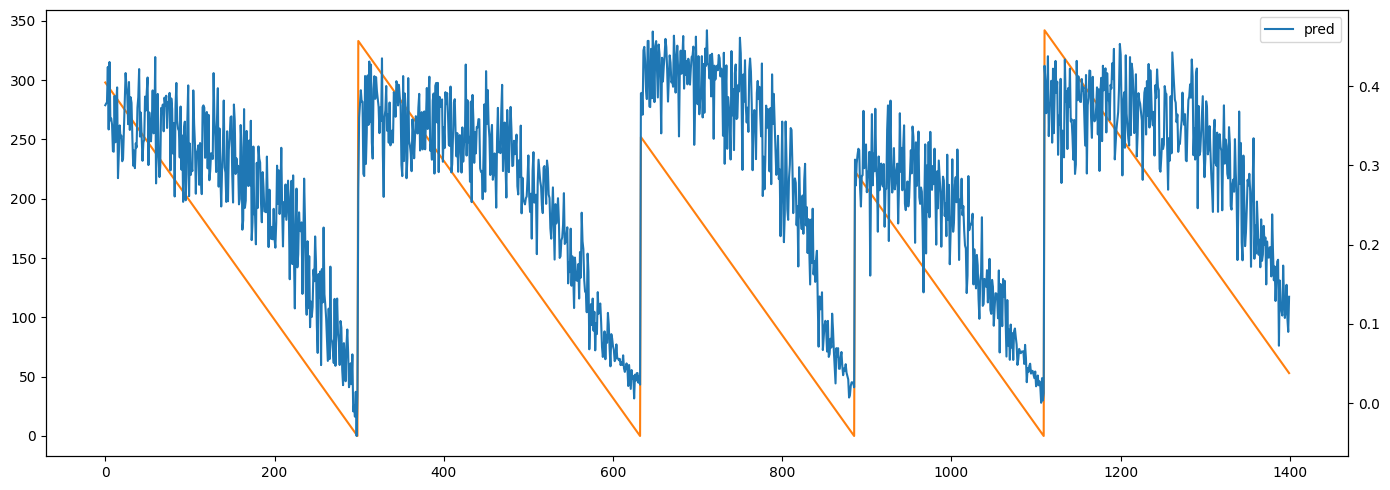

In [193]:
ts_pred = pred[0].ravel() * trmaxrul
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [190]:
mse_seeds, mse_mean, mse_std = evaluation(pred, ts_s)

Media della MSE: 0.0221
Deviazione standard della MSE: 0.0003


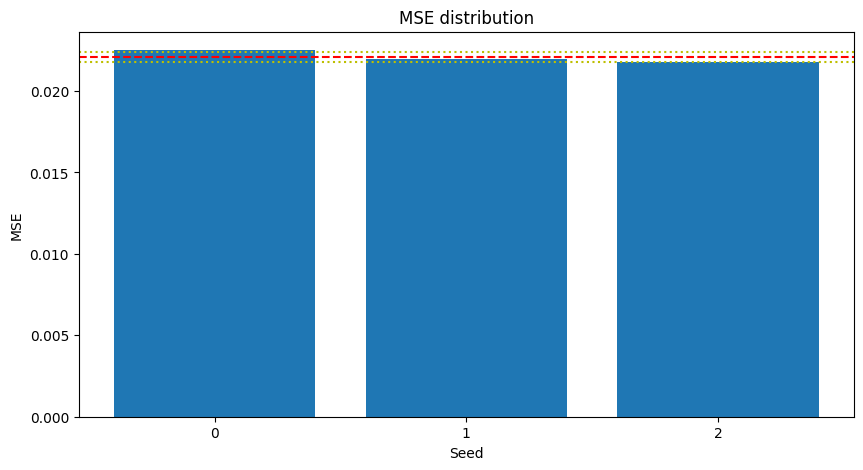

In [191]:
plot_results(mse_seeds, mse_mean, mse_std)

#### 1.3 50% of supervised data used for training

In [194]:
trs_3 = split_data(trs=trs, trs_ratio=0.50)

Num. samples: 22692 (supervised), 15864 (test)


In [195]:
trs_s = standardize(trs_3)
trmaxrul = trs_s['rul'].max()
ts_s = standardize(ts) 

In [196]:
pred = []
for i in range(3):
    np.random.seed(i)
    nn = cst.MLPRegressor(input_shape=len(dt_in), hidden=[32, 32])
    nn.compile(optimizer='Adam', loss='mse')
    history = nn.fit(trs_s[dt_in], trs_s['rul'], validation_split=0.2, batch_size=32, epochs=20, verbose=1)
    pred.append(nn.predict(ts_s[dt_in]).ravel() * trmaxrul)

Epoch 1/20
568/568 [==============================] - 1s 807us/step - loss: 0.0225 - val_loss: 0.0303
Epoch 2/20
568/568 [==============================] - 0s 632us/step - loss: 0.0131 - val_loss: 0.0244
Epoch 3/20
568/568 [==============================] - 0s 637us/step - loss: 0.0121 - val_loss: 0.0249
Epoch 4/20
568/568 [==============================] - 0s 804us/step - loss: 0.0117 - val_loss: 0.0223
Epoch 5/20
568/568 [==============================] - 0s 660us/step - loss: 0.0114 - val_loss: 0.0213
Epoch 6/20
568/568 [==============================] - 0s 692us/step - loss: 0.0112 - val_loss: 0.0225
Epoch 7/20
568/568 [==============================] - 0s 636us/step - loss: 0.0113 - val_loss: 0.0208
Epoch 8/20
568/568 [==============================] - 0s 661us/step - loss: 0.0110 - val_loss: 0.0212
Epoch 9/20
568/568 [==============================] - 0s 721us/step - loss: 0.0109 - val_loss: 0.0215
Epoch 10/20
568/568 [==============================] - 0s 671us/step - loss: 0.010

Evaluation on the test set

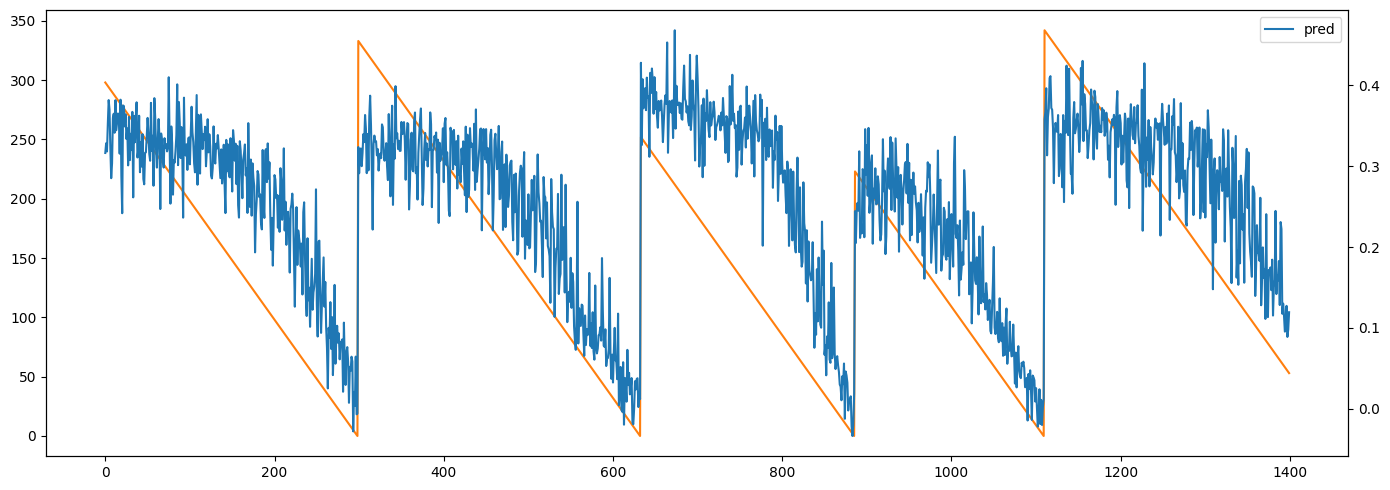

In [197]:
ts_pred = pred[0].ravel() * trmaxrul
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [198]:
mse_seeds, mse_mean, mse_std = evaluation(pred, ts_s)

Media della MSE: 0.0240
Deviazione standard della MSE: 0.0014


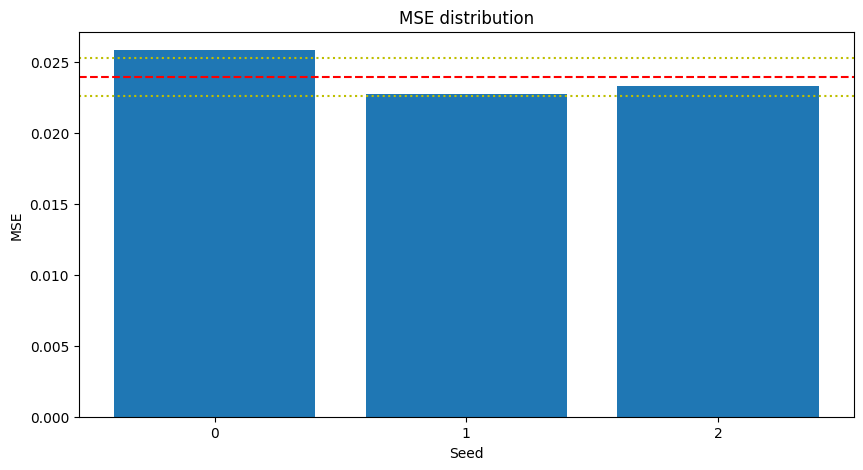

In [199]:
plot_results(mse_seeds, mse_mean, mse_std)

**results**

### Task 2: train the model with only unsupervised data. We will experiment with different ratios of supervised data. 


While training the models only with unsupervised data, we do not have great expectations. Indeed, using only unsupervised data there is no way the model can learn to predict the rul. However, we will see if it is possible for the regressor to learn the constraint which imposes that the rul for a machine should decrease. In comparison with the full supervised models, we expect that unsupervised models won't be able to predict the initial rul as accurately as the supervised models.

In [288]:
tru, ts = split_machines(dt, 0, 0.75)

Num. machines: 186 (unsupervised), 63 (test)


In [289]:
print(f'Num. samples: {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 45385 (unsupervised), 15864 (test)


#### 100% of unsupervised data

In [290]:
tru_s = standardize(tru)
trmaxrul = tru_s['rul'].max()
ts_s = standardize(ts)

Removing RUL Values

**We start by preparing a bit more the unsupervised data**

* First, we _remove the end_ of the unsupervised data sequences
* This simulate the fact that the machines are still operating

In [291]:
tru_st = remove_rul(tru_s)

/tmp/ipykernel_11/1631041332.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cutoff = int(np.random.randint(10, 50, 1))


In [293]:
#TODO validation split
pred = []
for i in range(3):
    nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=0, beta=1, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
    batch_gen = cst.CstBatchGenerator(tru_st, dt_in, batch_size=32, seed=i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    nn2.compile(optimizer='Adam', run_eagerly=False)
    history = nn2.fit(batch_gen, epochs=20, verbose=1, callbacks=cb)
    pred.append(nn.predict(ts_s[dt_in]).ravel() * trmaxrul)

Epoch 1/20
1339/1339 [==============================] - 4s 3ms/step - loss: 107.9503 - mse: 0.0000e+00 - cst: 107.9503
Epoch 2/20
1339/1339 [==============================] - 4s 3ms/step - loss: 107.6353 - mse: 0.0000e+00 - cst: 107.6353
Epoch 3/20
1339/1339 [==============================] - 4s 3ms/step - loss: 107.5600 - mse: 0.0000e+00 - cst: 107.5600
Epoch 4/20
1339/1339 [==============================] - 4s 3ms/step - loss: 106.3125 - mse: 0.0000e+00 - cst: 106.3125
Epoch 5/20
1339/1339 [==============================] - 4s 3ms/step - loss: 105.3331 - mse: 0.0000e+00 - cst: 105.3331
Epoch 6/20
1339/1339 [==============================] - 4s 3ms/step - loss: 104.4715 - mse: 0.0000e+00 - cst: 104.4715
Epoch 7/20
1339/1339 [==============================] - 4s 3ms/step - loss: 104.6687 - mse: 0.0000e+00 - cst: 104.6687
Epoch 8/20
1339/1339 [==============================] - 3s 3ms/step - loss: 105.0679 - mse: 0.0000e+00 - cst: 105.0679
Epoch 9/20
1339/1339 [==========================

In [ ]:
ts_pred = nn.predict(ts_s[dt_in]).ravel() * trmaxrul


Evaluation on the test set

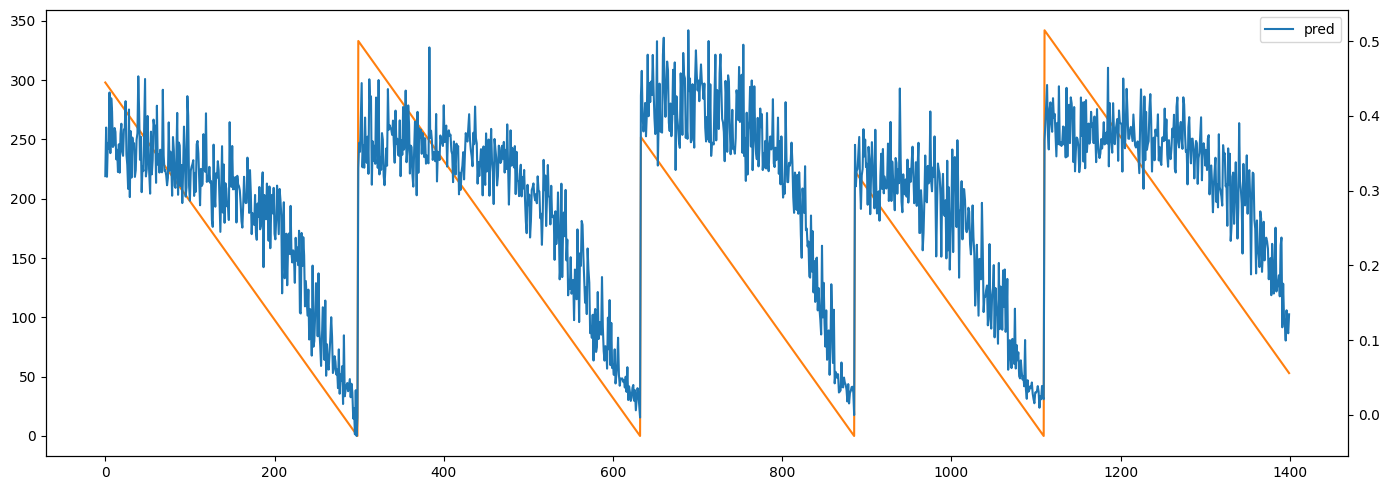

In [294]:
ts_pred = pred[0].ravel() * trmaxrul
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [295]:
mse_seeds, mse_mean, mse_std = evaluation(pred, ts_s)

Media della MSE: 0.0210
Deviazione standard della MSE: 0.0000


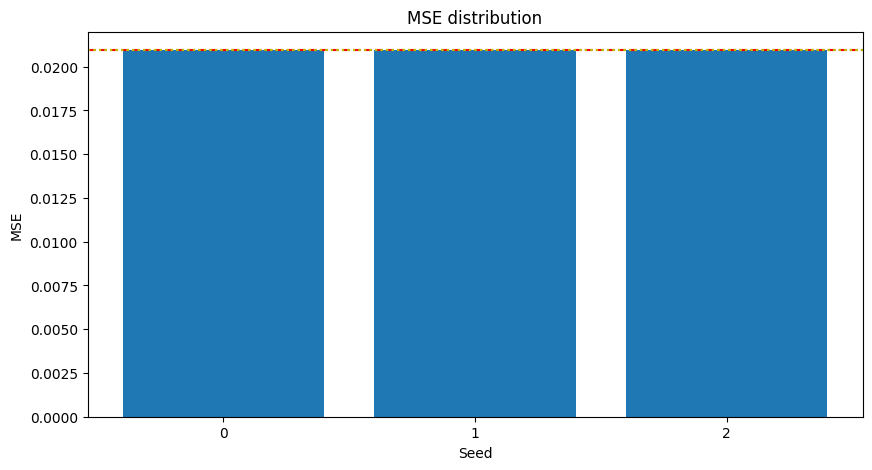

In [296]:
plot_results(mse_seeds, mse_mean, mse_std)

#### 75% of unsupervised data

In [271]:
tru_2 = split_data(tru=tru, tru_ratio=0.75)

Num. samples: 34038 (unsupervised), 15864 (test)


In [272]:
# standardize tru e ts 
tru_s = standardize(tru_2)
trmaxrul = tru_s['rul'].max()
ts_s = standardize(ts)

In [273]:
tru_st = remove_rul(tru_s)

/tmp/ipykernel_11/1631041332.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cutoff = int(np.random.randint(10, 50, 1))


In [274]:
pred = []
for i in range(3):
    np.random.seed(i)
    nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=0, beta=1, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
    batch_gen = cst.CstBatchGenerator(tru_st, dt_in, batch_size=32)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    nn2.compile(optimizer='Adam', run_eagerly=False)
    history = nn2.fit(batch_gen, epochs=20, verbose=1, callbacks=cb)
    pred.append(nn.predict(ts_s[dt_in]).ravel() * trmaxrul)

Epoch 1/20
1001/1001 [==============================] - 3s 2ms/step - loss: 109.7695 - mse: 0.0000e+00 - cst: 109.7695
Epoch 2/20
1001/1001 [==============================] - 2s 2ms/step - loss: 109.5576 - mse: 0.0000e+00 - cst: 109.5576
Epoch 3/20
1001/1001 [==============================] - 3s 3ms/step - loss: 107.7164 - mse: 0.0000e+00 - cst: 107.7164
Epoch 4/20
1001/1001 [==============================] - 2s 2ms/step - loss: 108.5206 - mse: 0.0000e+00 - cst: 108.5206
Epoch 5/20
1001/1001 [==============================] - 2s 2ms/step - loss: 106.8260 - mse: 0.0000e+00 - cst: 106.8260
Epoch 6/20
1001/1001 [==============================] - 2s 2ms/step - loss: 105.8217 - mse: 0.0000e+00 - cst: 105.8217
Epoch 7/20
1001/1001 [==============================] - 2s 2ms/step - loss: 106.0552 - mse: 0.0000e+00 - cst: 106.0552
Epoch 8/20
1001/1001 [==============================] - 2s 2ms/step - loss: 105.2139 - mse: 0.0000e+00 - cst: 105.2139
Epoch 9/20
1001/1001 [==========================

Evaluation on the test set

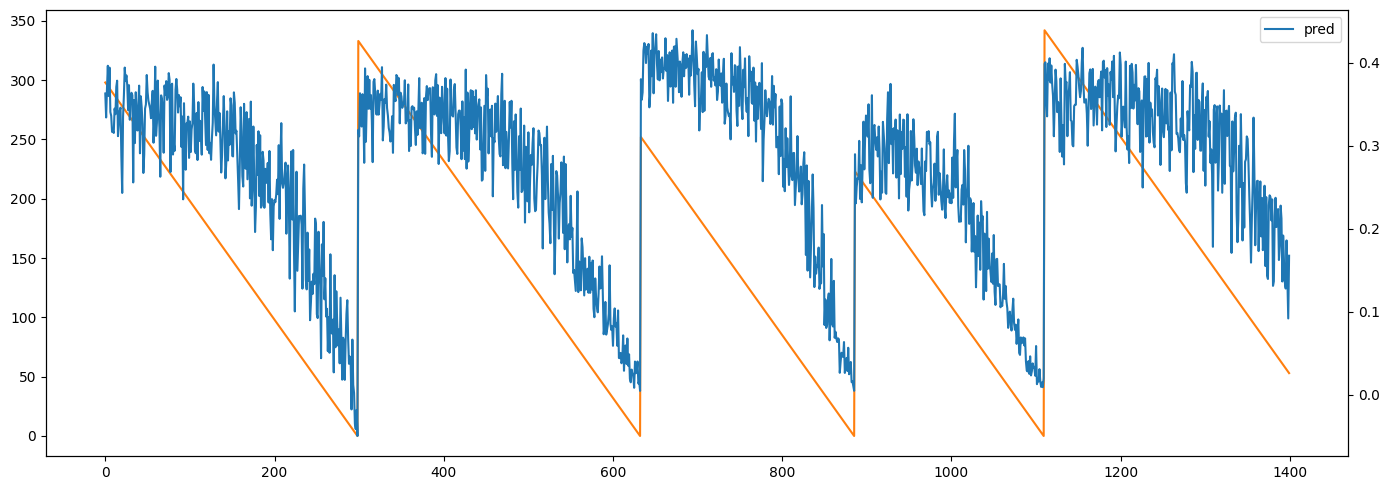

In [276]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

496/496 [==============================] - 1s 2ms/step


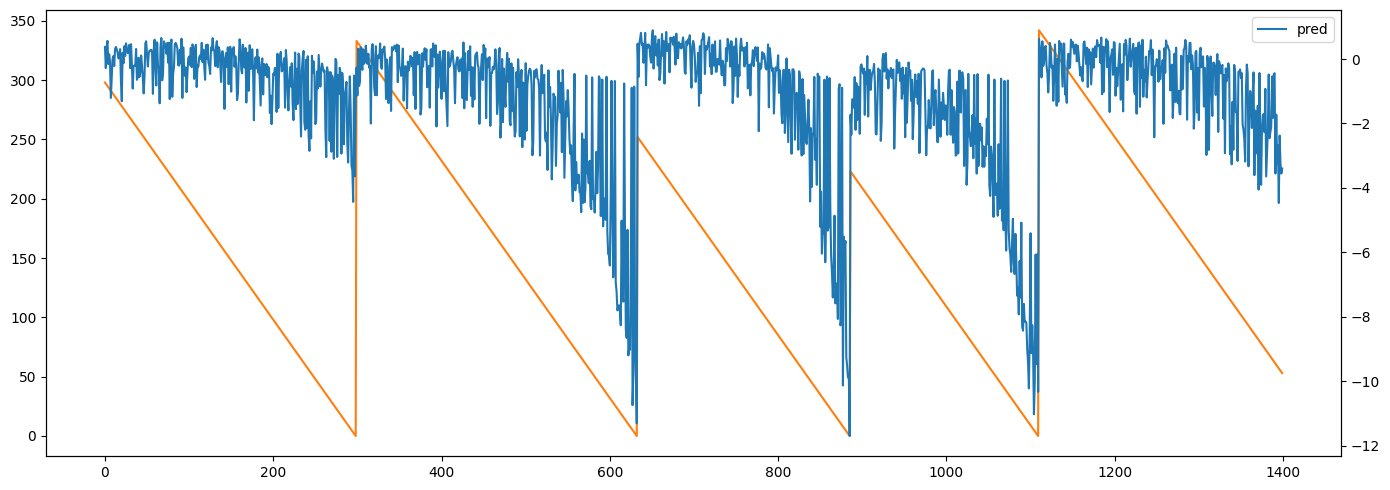

In [62]:
#risultati precedenti
ts_pred = pred[0].ravel() * trmaxrul
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [277]:
mse_seeds, mse_mean, mse_std = evaluation(pred, ts_s)

Media della MSE: 0.0233
Deviazione standard della MSE: 0.0000


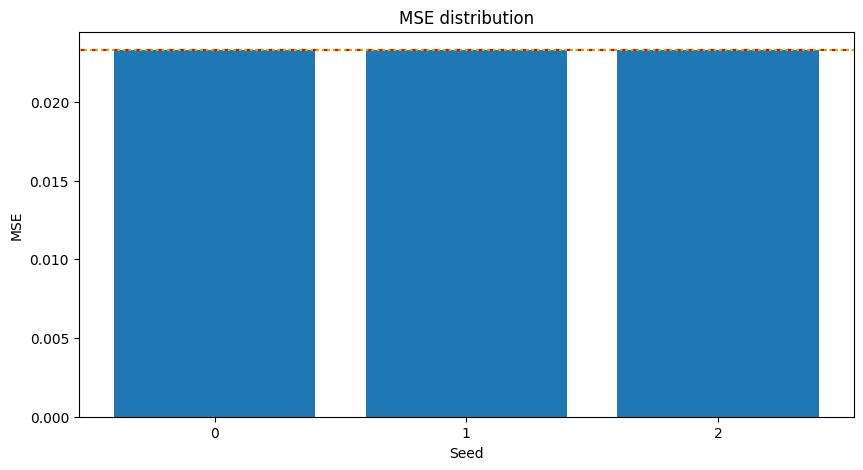

In [278]:
plot_results(mse_seeds, mse_mean, mse_std)

#### 50% of unsupervised

In [279]:
tru_2 = split_data(tru=tru, tru_ratio=0.50)

Num. samples: 22692 (unsupervised), 15864 (test)


In [280]:
# standardize tru e ts 
tru_s = standardize(tru_2)
trmaxrul = tru_s['rul'].max()
ts_s = standardize(ts)

In [281]:
tru_st = remove_rul(tru_s)

/tmp/ipykernel_11/1631041332.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cutoff = int(np.random.randint(10, 50, 1))


In [282]:
pred = []
for i in range(3):
    np.random.seed(i)
    nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=0, beta=1, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
    batch_gen = cst.CstBatchGenerator(tru_st, dt_in, batch_size=32)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    nn2.compile(optimizer='Adam', run_eagerly=False)
    history = nn2.fit(batch_gen, epochs=20, verbose=1, callbacks=cb)
    pred.append(nn.predict(ts_s[dt_in]).ravel() * trmaxrul)

Epoch 1/20
670/670 [==============================] - 2s 2ms/step - loss: 105.5572 - mse: 0.0000e+00 - cst: 105.5572
Epoch 2/20
670/670 [==============================] - 1s 2ms/step - loss: 103.5740 - mse: 0.0000e+00 - cst: 103.5740
Epoch 3/20
670/670 [==============================] - 1s 2ms/step - loss: 103.6964 - mse: 0.0000e+00 - cst: 103.6964
Epoch 4/20
670/670 [==============================] - 1s 2ms/step - loss: 103.5460 - mse: 0.0000e+00 - cst: 103.5460
Epoch 5/20
670/670 [==============================] - 1s 2ms/step - loss: 101.9371 - mse: 0.0000e+00 - cst: 101.9371
Epoch 6/20
670/670 [==============================] - 1s 2ms/step - loss: 105.0050 - mse: 0.0000e+00 - cst: 105.0050
Epoch 7/20
670/670 [==============================] - 1s 2ms/step - loss: 103.9287 - mse: 0.0000e+00 - cst: 103.9287
Epoch 8/20
670/670 [==============================] - 1s 2ms/step - loss: 101.8490 - mse: 0.0000e+00 - cst: 101.8490
Epoch 9/20
670/670 [==============================] - 1s 2ms/ste

Evaluation on the test set

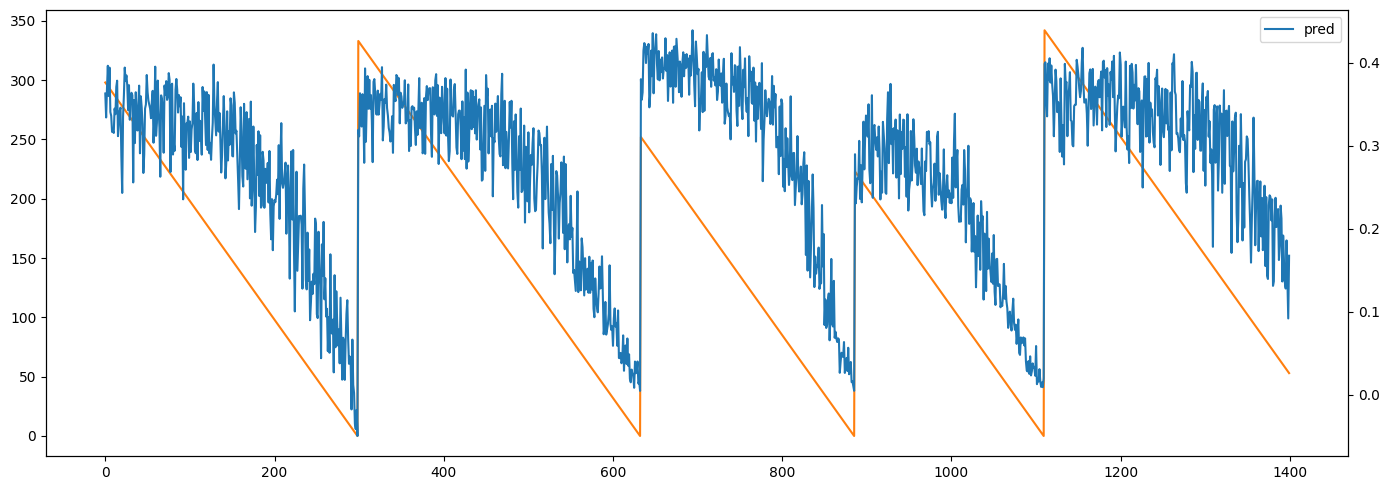

In [283]:
ts_pred = pred[0].ravel() * trmaxrul
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

496/496 [==============================] - 1s 2ms/step


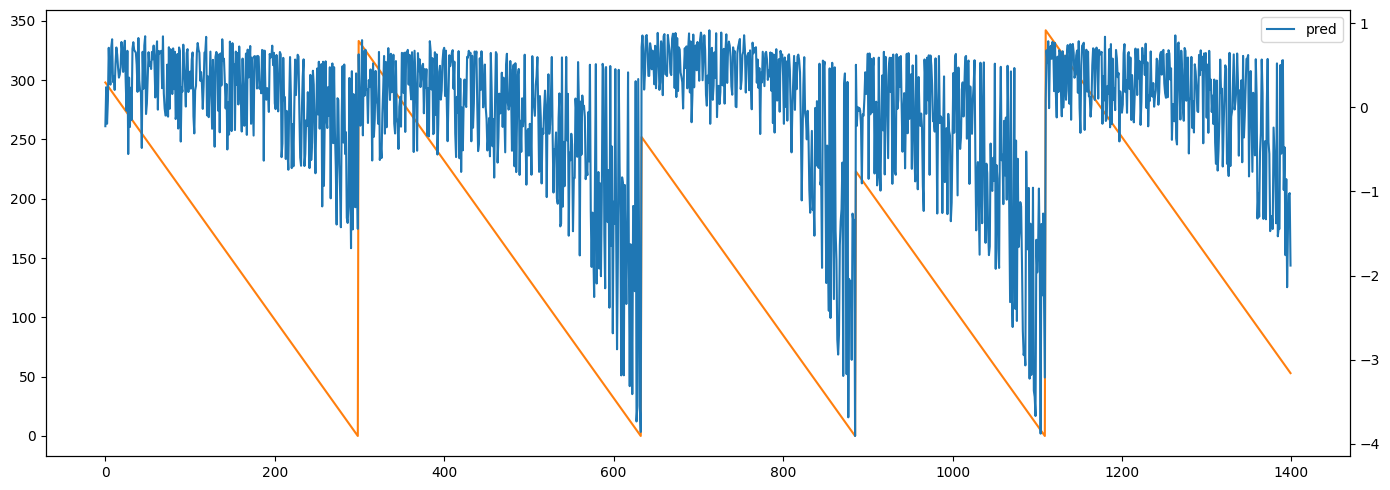

In [67]:
ts_pred = pred[0].ravel() * trmaxrul
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [284]:
mse_seeds, mse_mean, mse_std = evaluation(pred, ts_s)

Media della MSE: 0.0233
Deviazione standard della MSE: 0.0000


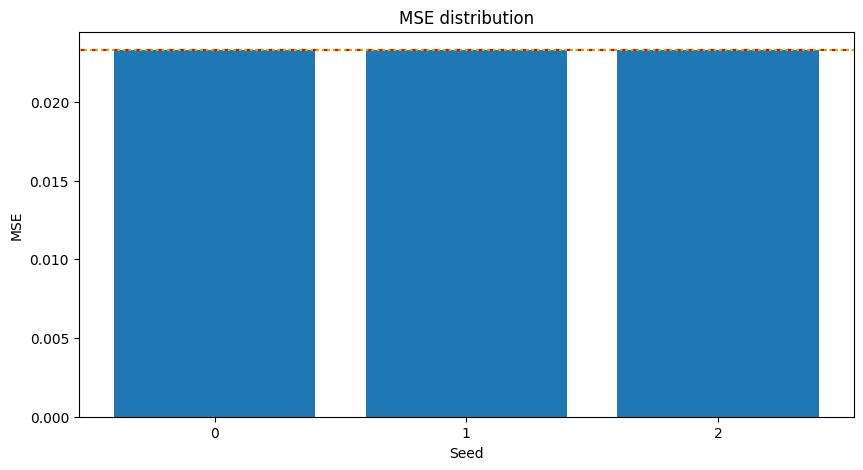

In [285]:
plot_results(mse_seeds, mse_mean, mse_std)

**results**
meglio del previsto

### Task 3: train the model with both supervised and unsupervised data. We will experiment with different ratios of unsupervised and supervised data. 


We expect that the performances of models trained with both supervised and unsupervied data will lay in between those of the models trained just with supervised data and the models trained with only unsupervised data, meaning that they will have better performances wrt the unsupervised models, but worse than those of supervised models. Moreover, changing the ratio will greatly influence the performances of the models. *scrivere per le combinazioni*
- increasing the number of supervised samples, with fixed unsupervised samples, will lead to a more performing model
- increasing the number of unsupervised samples, with fixed supervised samples, will lead to a less performing model


In [255]:
#parte nuova
tr, ts, trs, tru = split_machines(dt, 0.50, 0.75)

Num. machines: 124 (supervised), 62 (unsupervised), 63 (test)


In [256]:
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 30572 (supervised), 14813 (unsupervised), 15864 (test)


In [257]:
# standardize tru e ts e trs
tru_s = standardize(tru)
trmaxrul = tru_s['rul'].max()
ts_s = standardize(ts)
trs_s = standardize(trs)

In [258]:
tru_st = remove_rul(tru_s)

/tmp/ipykernel_11/1631041332.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cutoff = int(np.random.randint(10, 50, 1))


In [259]:
trsu_s = pd.concat((trs_s, tru_st))

In [260]:
# fai test con alpha = 1 e beta = 5 (come faceva il prof per il mix)
nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=0, beta=1, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
batch_gen = cst.CstBatchGenerator(trsu_s, dt_in, batch_size=32)
cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
nn2.compile(optimizer='Adam', run_eagerly=False)
history = nn2.fit(batch_gen, epochs=5, verbose=1, callbacks=cb)

Epoch 1/5
1465/1465 [==============================] - 4s 3ms/step - loss: 124.5045 - mse: 0.1617 - cst: 124.5045
Epoch 2/5
1465/1465 [==============================] - 4s 3ms/step - loss: 121.7646 - mse: 0.7725 - cst: 121.7646
Epoch 3/5
1465/1465 [==============================] - 4s 3ms/step - loss: 121.1747 - mse: 3.5487 - cst: 121.1747
Epoch 4/5
1465/1465 [==============================] - 4s 3ms/step - loss: 120.2364 - mse: 6.8375 - cst: 120.2364
Epoch 5/5
1465/1465 [==============================] - 4s 3ms/step - loss: 119.5118 - mse: 10.1947 - cst: 119.5118


In [ ]:
# predict loop

**results**

## Evaluation

**The RUL Predictions follow the trend already identified**

...But they are much more noisy, due to the small size of the training set

43/43 [==============================] - 0s 479us/step


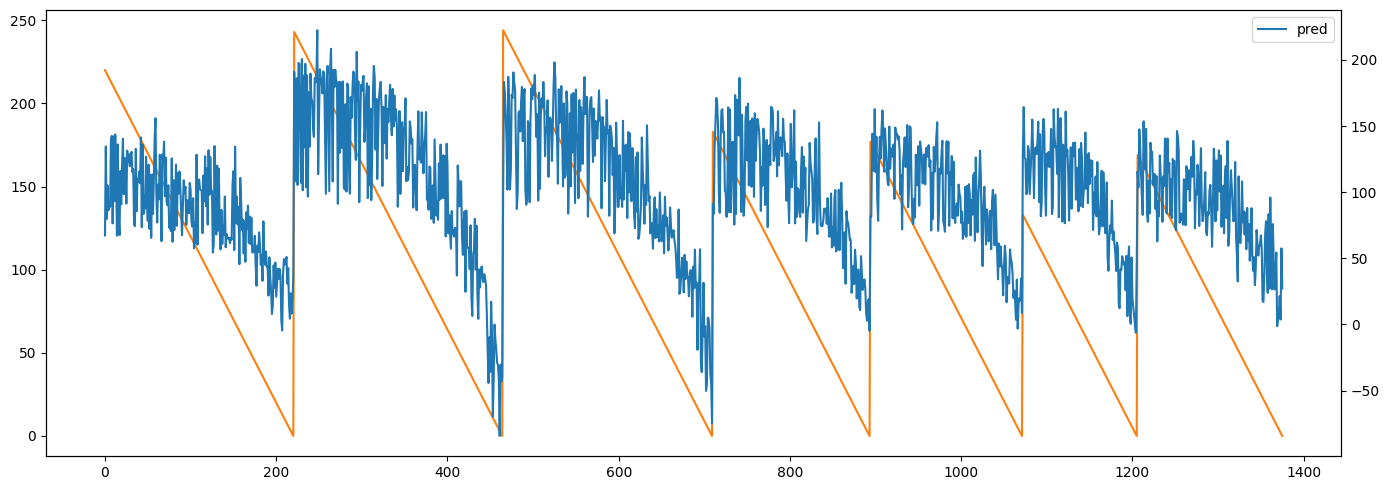

In [13]:
trs_pred = nn.predict(trs_s[dt_in]).ravel() * trmaxrul
stop = 1400 
cst.plot_rul(trs_pred[:stop], trs["rul"].iloc[:stop], same_scale=False, figsize=figsize)

## Evaluation

**The behavior on the unsupervised data is very similar**

...And similarly noisy

1376/1376 [==============================] - 1s 530us/step


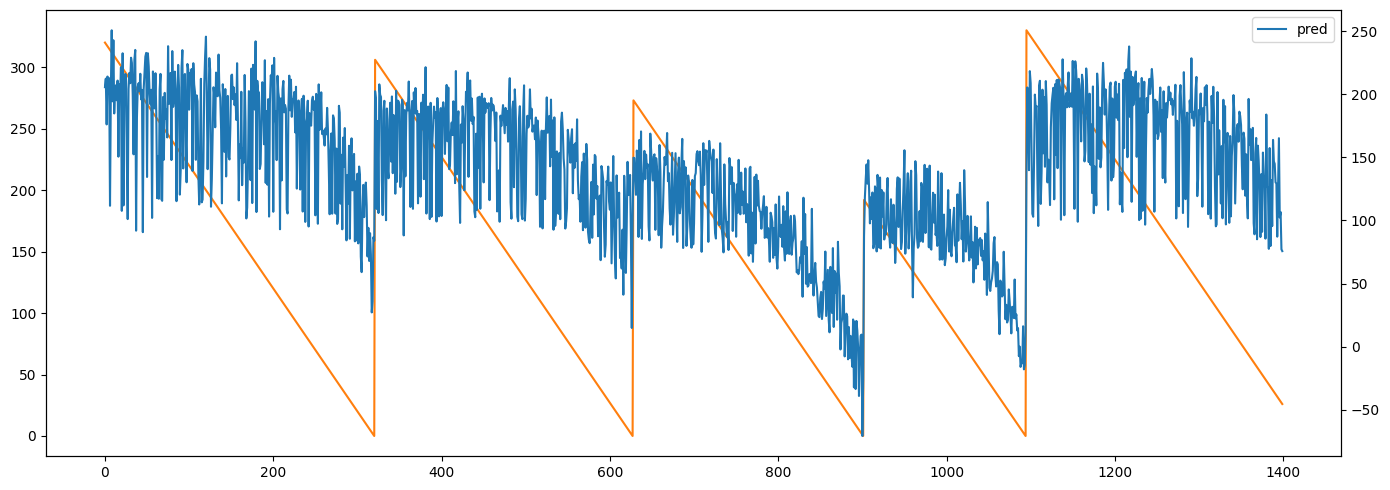

In [14]:
tru_pred = nn.predict(tru_s[dt_in]).ravel() * trmaxrul
cst.plot_rul(tru_pred[:stop], tru["rul"].iloc[:stop], same_scale=False, figsize=figsize)

## Evaluation

**The same goes for the data in the test set**

496/496 [==============================] - 0s 524us/step


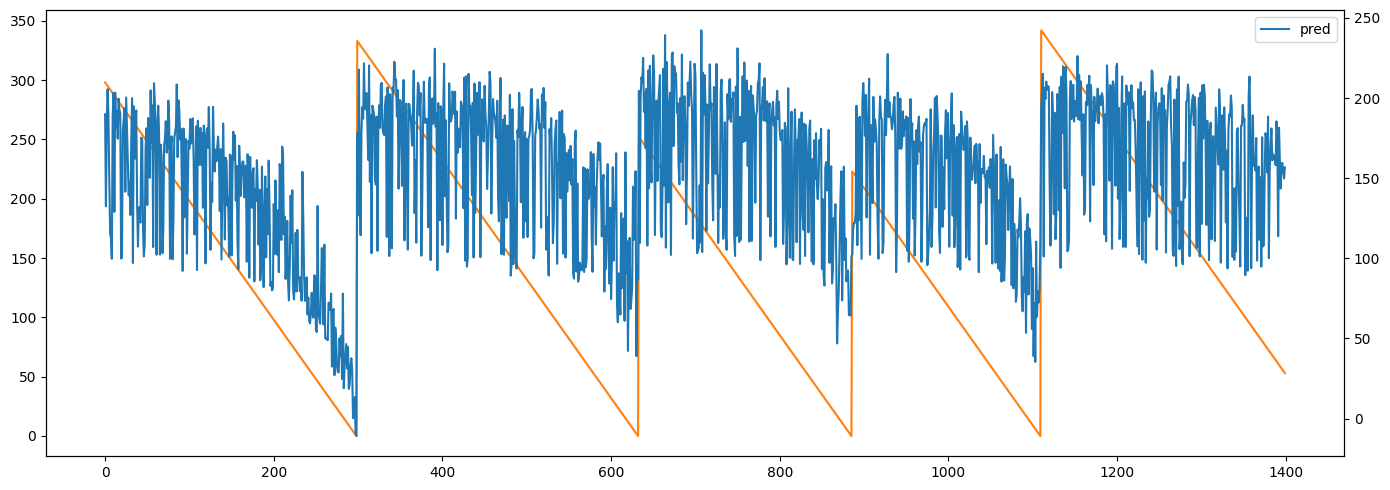

In [15]:
ts_pred = nn.predict(ts_s[dt_in]).ravel() * trmaxrul
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

## Cost Model and Threshold Optimization

**We then proceed to define a cost model**

Optimal threshold for the training set: 4


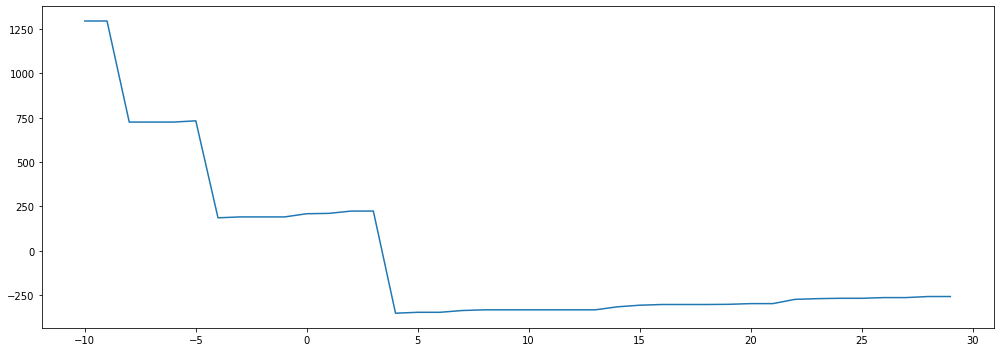

In [14]:
failtimes = dt.groupby('machine')['cycle'].max() 
safe_interval, maintenance_cost = failtimes.min(), failtimes.max()

cmodel = cst.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)
th_range = np.arange(-10, 30)
trs_thr = cst.opt_threshold_and_plot(trs_s['machine'].values, trs_pred, th_range, cmodel, figsize=figsize)
print(f'Optimal threshold for the training set: {trs_thr}')

## Cost Results

**The cost on the training set is still good...**

...But that is not true for the unsupervised experiments and the test set

In [15]:
trs_c, trs_f, trs_sl = cmodel.cost(trs_s['machine'].values, trs_pred, trs_thr, return_margin=True)
tru_c, tru_f, tru_sl = cmodel.cost(tru_s['machine'].values, tru_pred, trs_thr, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts['machine'].values, ts_pred, trs_thr, return_margin=True)
print(f'Cost: {trs_c} (supervised), {tru_c} (unsupervised), {ts_c} (test)')

Cost: -352 (supervised), 34750 (unsupervised), 13408 (test)


In [16]:
trs_nm, tru_nm, ts_nm = len(trs_mcn), len(tru_mcn), len(ts_mcn)
print(f'Avg. fails: {trs_f/trs_nm:.2f} (supervised), {tru_f/tru_nm:.2f} (unsupervised), {ts_f/ts_nm:.2f} (test)')
print(f'Avg. slack: {trs_sl/trs_nm:.2f} (supervised), {tru_sl/tru_nm:.2f} (unsupervised), {ts_sl/len(ts_mcn):.2f} (test)')

Avg. fails: 0.00 (supervised), 0.43 (unsupervised), 0.46 (test)
Avg. slack: 18.29 (supervised), 11.08 (unsupervised), 9.83 (test)


* In particular, there is a _very high failure rate on unseen data_

# Domain Knowledge as Constraints

## Domain Knowledge as Constraints

**We know that the RUL _decreases at a fixed rate_**

* After 1 time step, the RUL will have decreased by 1 unit
* After 2 time steps, the RUL will have decreased by 2 units and so on

**In general, let $\hat{x}_i$ and $\hat{x}_j$ be the $i$-th and $j$-th samples _for a given component_**

Then we know that:

$$\begin{align}
& f(\hat{x}_i, \omega) - f(\hat{x}_j, \omega) = j - i & \forall i, j = 1..m \text{ s.t. } c_i = c_j
\end{align}$$

* $c_i, c_j$ are the components for (respectively) sample $i$ and $j$
* Samples are assumed to be _temporally sorted_
* The left-most terms is the difference between the predicted RULs
* $j -i$ is the difference between the sequential indexes of the two samples
* ...Which by construction should be equal to the RUL difference

## Domain Knowledge as Constraints

**The relation we identified is a _constraint_**

$$\begin{align}
& f(\hat{x}_i, \omega) - f(\hat{x}_j, \omega) = j - i & \forall i, j = 1..m \text{ s.t. } c_i = c_j
\end{align}$$

It represents domain knowledge that should (in principle) hold for our problem

* We don't need _strict satisfaction_: we can treat it as a _soft constraint_
* The constraint involves pairs of example, i.e. it is a _relational constraint_

**A simple approach: use the constraint to derive a _semantic regularizer_**

This approach is sometimes known as _Semantic Based Regularization_

* The regularizer represents a constraint that we think should generally hold
* ...It is meant to _assist the model_ by ensuring better generalization
* ...Or by speeding up the training process
* ...Or by allowing one to take advantage of (otherwise) unsupervised data


## Our Regularizer

**We need to design a regualizer for our constraint**

$$\begin{align}
& f(\hat{x}_i, \omega) - f(\hat{x}_j, \omega) = j - i & \forall i, j = 1..m \text{ s.t. } c_i = c_j
\end{align}$$

The regualizer should penalize violations of the constraint, e.g.
$$
\lambda \left(f(\hat{x}_i, \omega) - f(\hat{x}_j, \omega) - (j-i)\right)^2
$$

* Using the absolute value (h1 norm) may also work

**In principle, we should consider all valid pairs**

Such an approach would lead to the following loss function:
$$
L(\hat{x}, \omega) + \lambda \sum_{i=1..m} \sum_{\substack{j=i+1..m\\ c_i = c_j}} \left(f(\hat{x}_i, \omega) - f(\hat{x}_j, \omega) - (j-i)\right)^2
$$

* The $\lambda$ parameter balances the two loss terms

## Our Regularizer

**We can focus on contiguous pairs, i.e.**

$$
L(\hat{x}, \omega) + \lambda \sum_{\substack{i \prec j \\ c_i = c_j}} \left(f(\hat{x}_i, \omega) - f(\hat{x}_j, \omega) - (j-i)\right)^2
$$

* Where $i \prec j$ iff $j$ is the next sample for after $i$ for a given machine 
* This approach requires a linear (rather than quadratic) number of constraints

**It can work with mini-batches**

* In this case, $\prec$ will refer to contiguous samples _in the same batch_
* ...And of course for the same component

**We will now see how to implement this approach**

## Removing RUL Values

**We start by preparing a bit more the unsupervised data**

* First, we _remove the end_ of the unsupervised data sequences
* This simulate the fact that the machines are still operating

In [16]:
tru_s_by_m = cst.split_by_field(tru_s, 'machine')
np.random.seed(42)
for mcn, tmp in tru_s_by_m.items():
    cutoff = int(np.random.randint(10, 50, 1))
    tru_s_by_m[mcn] = tmp.iloc[:-cutoff]
tru_st = pd.concat(tru_s_by_m.values())

/tmp/ipykernel_11/2313383895.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cutoff = int(np.random.randint(10, 50, 1))


Then we assign an invalid value to the RUL for unsupervised data:

In [17]:
#trsu_s = pd.concat((trs_s, tru_st))
trsu_s.loc[tru_st.index, 'rul'] = -1

In [ ]:
nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=0, beta=1, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
batch_gen = cst.CstBatchGenerator(trsu_s, dt_in, batch_size=32)
cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
nn2.compile(optimizer='Adam', run_eagerly=False)
history = nn2.fit(batch_gen, epochs=20, verbose=1, callbacks=cb)

We also buid a single dataset containing both supervised and unsupervised data

## The SBR Approach: Fully Unsupervised Training

**We can now train our SBR-based approach**

We will make a first attempt with a pure unsupervised training:

In [25]:
nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=0, beta=1, maxrul=trmaxrul, hidden=[32, 32])
batch_gen = cst.CstBatchGenerator(trsu_s, dt_in, batch_size=32)
cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
nn2.compile(optimizer='Adam', run_eagerly=False)
history = nn2.fit(batch_gen, epochs=20, verbose=1, callbacks=cb)

Epoch 1/20
1350/1350 [==============================] - 11s 8ms/step - loss: 0.0020 - mse: 0.0038 - cst: 0.0020
Epoch 2/20
1350/1350 [==============================] - 14s 10ms/step - loss: 5.1125e-04 - mse: 0.0013 - cst: 5.1125e-04
Epoch 3/20
1350/1350 [==============================] - 10s 7ms/step - loss: 4.4885e-04 - mse: 7.6831e-04 - cst: 4.4885e-04
Epoch 4/20
1350/1350 [==============================] - 15s 11ms/step - loss: 4.1754e-04 - mse: 4.6579e-04 - cst: 4.1754e-04
Epoch 5/20
1350/1350 [==============================] - 10s 8ms/step - loss: 4.0965e-04 - mse: 4.2318e-04 - cst: 4.0965e-04
Epoch 6/20
1350/1350 [==============================] - 6s 4ms/step - loss: 3.9508e-04 - mse: 4.7502e-04 - cst: 3.9508e-04
Epoch 7/20
1350/1350 [==============================] - 6s 4ms/step - loss: 3.8626e-04 - mse: 6.1249e-04 - cst: 3.8626e-04
Epoch 8/20
1350/1350 [==============================] - 14s 10ms/step - loss: 3.7855e-04 - mse: 7.2692e-04 - cst: 3.7855e-04
Epoch 9/20
1350/1350 [=

## Inspecting the Predictions

**Then let's check the predictions for the _test data_**

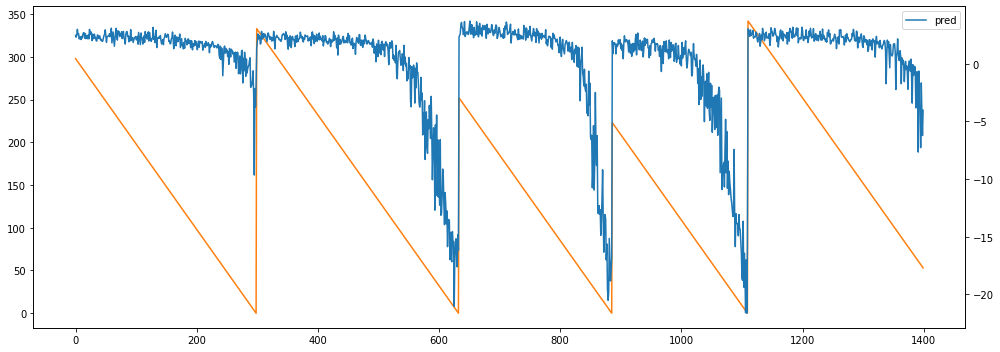

In [23]:
ts_pred = nn2.predict(ts_s[dt_in]).ravel() * trmaxrul
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

* In many cases, we are already obtaining the trend we are familiar with!
* The scale is however completely off

## The SBR Approach

**Let's try again using _both supervised and unsupervised data_:**

In [26]:
nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=1, beta=5, maxrul=trmaxrul, hidden=[32, 32])
batch_gen = cst.CstBatchGenerator(trsu_s, dt_in, batch_size=32)
cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
nn2.compile(optimizer='Adam', run_eagerly=False)
history = nn2.fit(batch_gen, epochs=20, verbose=1, callbacks=cb)

Epoch 1/20
1350/1350 [==============================] - 6s 4ms/step - loss: 0.0060 - mse: 7.9022e-04 - cst: 0.0010
Epoch 2/20
1350/1350 [==============================] - 8s 6ms/step - loss: 0.0027 - mse: 4.4355e-04 - cst: 4.4750e-04
Epoch 3/20
1350/1350 [==============================] - 9s 6ms/step - loss: 0.0026 - mse: 4.4138e-04 - cst: 4.2749e-04
Epoch 4/20
1350/1350 [==============================] - 8s 6ms/step - loss: 0.0025 - mse: 4.3010e-04 - cst: 4.1182e-04
Epoch 5/20
1350/1350 [==============================] - 6s 5ms/step - loss: 0.0024 - mse: 4.3058e-04 - cst: 3.9663e-04
Epoch 6/20
1350/1350 [==============================] - 11s 8ms/step - loss: 0.0024 - mse: 4.3272e-04 - cst: 3.8564e-04
Epoch 7/20
1350/1350 [==============================] - 10s 7ms/step - loss: 0.0023 - mse: 4.2655e-04 - cst: 3.7846e-04
Epoch 8/20
1350/1350 [==============================] - 7s 5ms/step - loss: 0.0023 - mse: 4.1576e-04 - cst: 3.7353e-04
Epoch 9/20
1350/1350 [============================

## Inspecting the Predictions

**Let's have a look at the predictions on the _supervised_ data**

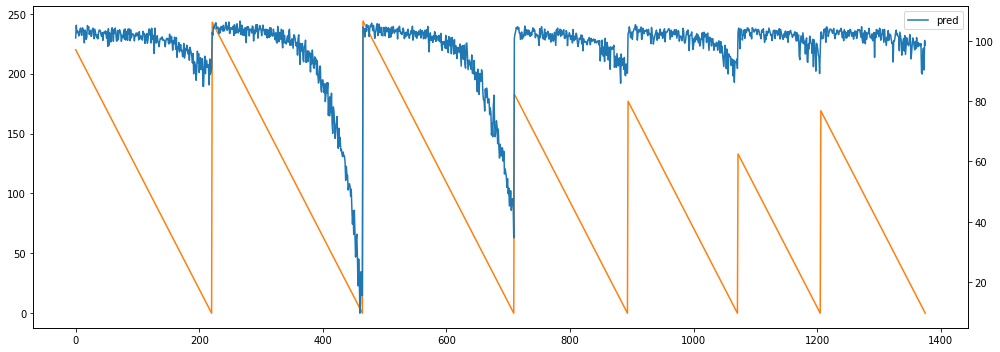

In [27]:
trs_pred = nn2.predict(trs_s[dt_in]).ravel() * trmaxrul
cst.plot_rul(trs_pred[:stop], trs["rul"].iloc[:stop], same_scale=False, figsize=figsize)

* The signal is _very stable_
* The scale is still off, but the approach will generally lead to overestimations
* ...However, we can fix that with a well chosen threshold

## Inspecting the Predictions

**Then let's do the same for the _unsupervised_ data**

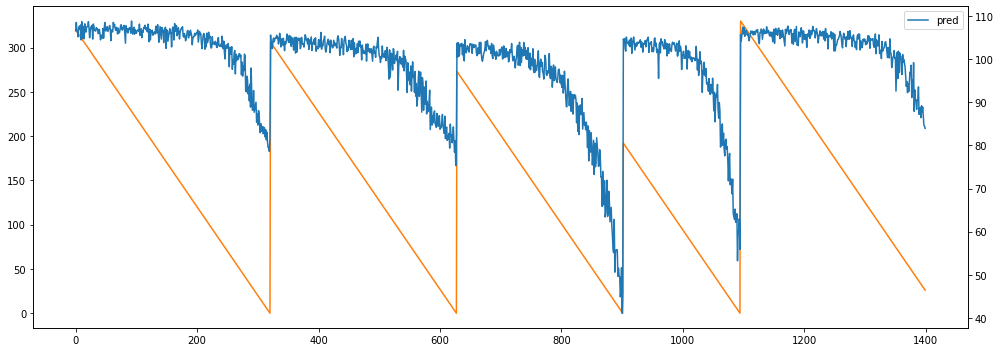

In [28]:
tru_pred = nn2.predict(tru_s[dt_in]).ravel() * trmaxrul
cst.plot_rul(tru_pred[:stop], tru["rul"].iloc[:stop], same_scale=False, figsize=figsize)

## Inspecting the Predictions

**Then let's do the same for the _test_ data**

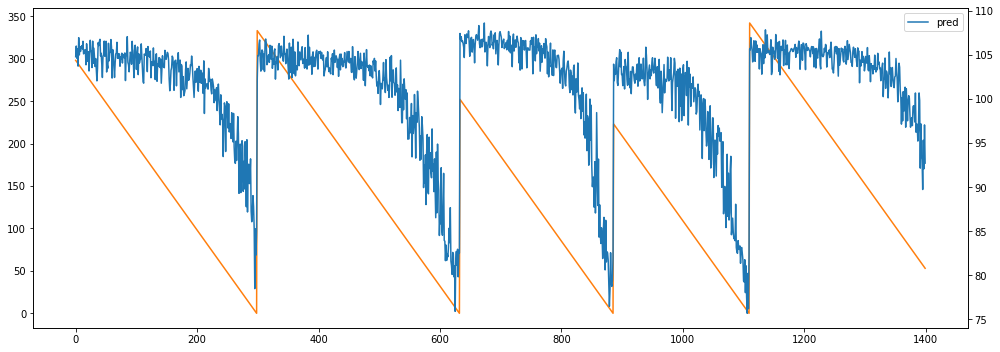

In [29]:
ts_pred = nn2.predict(ts_s[dt_in]).ravel() * trmaxrul
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

The behavior is more stable and consistent than before

## Threshold Optimization and Cost Evaluation

**We can now optimize the threshold (on the supervised data)**

Optimal threshold for the training set: 90


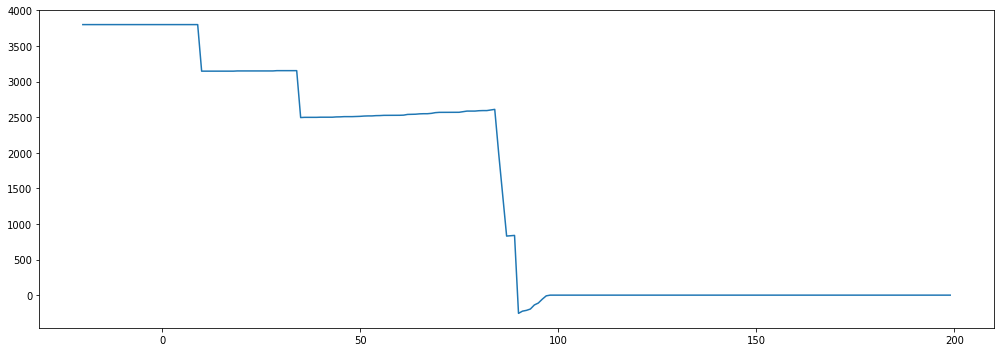

In [30]:
cmodel = cst.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)
th_range = np.arange(-20, 200)
trs_thr = cst.opt_threshold_and_plot(trs_s['machine'].values, trs_pred, th_range, cmodel, figsize=figsize)
print(f'Optimal threshold for the training set: {trs_thr}')

## Threshold Optimization and Cost Evaluation

**Finally, we can evaluate the SBR approach in terms of cost**

In [31]:
trs_c, trs_f, trs_sl = cmodel.cost(trs_s['machine'].values, trs_pred, trs_thr, return_margin=True)
tru_c, tru_f, tru_sl = cmodel.cost(tru_s['machine'].values, tru_pred, trs_thr, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts['machine'].values, ts_pred, trs_thr, return_margin=True)
print(f'Cost: {trs_c} (supervised), {tru_c} (unsupervised), {ts_c} (test)')

Cost: -256 (supervised), -7092 (unsupervised), -2275 (test)


In [32]:
print(f'Avg. fails: {trs_f/len(trs_mcn):.2f} (supervised), {tru_f/len(tru_mcn):.2f} (unsupervised), {ts_f/len(ts_mcn):.2f} (test)')
print(f'Avg. slack: {trs_sl/len(trs_mcn):.2f} (supervised), {tru_sl/len(tru_mcn):.2f} (unsupervised), {ts_sl/len(ts_mcn):.2f} (test)')

Avg. fails: 0.00 (supervised), 0.07 (unsupervised), 0.08 (test)
Avg. slack: 32.29 (supervised), 39.12 (unsupervised), 41.62 (test)


* The number of fails has decreased very significantly
* The slack is still contained

And we did this with just a handful of run-to-failure experiments

## Considerations

**Regularized approaches for knowledge injection are very versatile**

They work as long as we have a good _differentiable regularizer_

* E.g. negative labels (here we assume a one-hot encoding for the output)
  * Constraint: $\mathit{round}(f_j(\hat{x}_i)) \neq 1$
  * A possbible regularizer: $f_j(\hat{x}_i)$
* E.g. subclass-class relations in multiclass classification
  * Constraint: $\mathit{round}(f_j(\hat{x}_i)) \Rightarrow \mathit{round}(f_k(\hat{x}_i))$ if $j$ is a subclass of $k$
  * A possible regularizer: $\max\left(0, f_j(\hat{x}_i) - f_k(\hat{x}_i)\right)$
* E.g. logical formulas can be translated into regularizers by mean of fuzzy logic

**Choosing the correct regularizer weight can be complicated**

* Since the is still improving generalization, we could use a validation set
* However, if supervised data is scarce this may not be practical
* In general: an open research problem

## Considerations

**Domain knowledge is ubiquitous**

* It is sometimes contrasted with deep learning
* ...But isn't it better to use both?


**Differentiability may be an issue**

* Some constraints are not naturally differentiable
* E.g. say we know that the (binary) classes are roughly balanced
  - The constraint: $\sum_{i=1}^m \mathit{round}(f(\hat{x}_i)) = m/2$
  - A possible regularizer: $\left(\sum_{i=1}^m f(\hat{x}_i) - m/2\right)^2$
* The penalty can be minimized by balancing the classes...
* ...But also by predicting 0.5 (complete uncertainty) for all examples!
* This is another open research issue